In [1]:
import torch
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch import nn
from torchsummary import summary

train_iter = iter(AG_NEWS(split="train"))

c:\Users\manmu\anaconda3\envs\aio\lib\site-packages\torchtext\datasets\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\manmu\anaconda3\envs\aio\lib\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\manmu\anaconda3\envs\aio\lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABO

In [2]:
next(train_iter)

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

## Prepare data processing pipelines

In [3]:
tokenizer = get_tokenizer("basic_english")
train_iter = AG_NEWS(split="train")

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1
label_pipeline

<function __main__.<lambda>(x)>

In [4]:
vocab(['here', 'is', 'an', 'example'])

[475, 21, 30, 5297]

## Generate data batch and iterator

In [5]:
BATCH_SIZE = 128

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = random_split(
    train_dataset, [num_train, len(train_dataset) - num_train]
)

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)

max_lenght = max([len(tokenizer(text)) for (label, text) in train_iter])


In [6]:
print(f'Max lenght: {max_lenght}')
embed_dim = 8

Max lenght: 207


## Define Model 

In [7]:
pe = torch.zeros(max_lenght, embed_dim)
print(pe.shape)
position = torch.arange(0, max_lenght, dtype=torch.float).unsqueeze(1)
print(position.shape)
div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))
pe[:, 0::2] = torch.sin(position * div_term)
pe[:, 1::2] = torch.cos(position * div_term)
pe = pe.unsqueeze(0).transpose(0, 1)
print(pe.shape)

torch.Size([207, 8])
torch.Size([207, 1])
torch.Size([207, 1, 8])


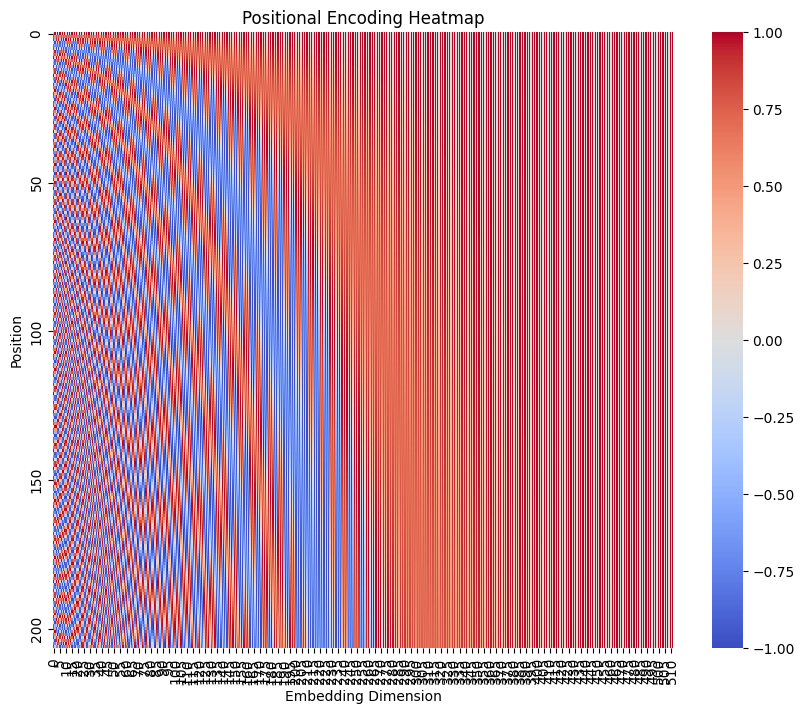

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term_sin = torch.exp(torch.arange(0, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))
        div_term_cos = torch.exp(torch.arange(1, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))

        pe[:, 0::2] = torch.sin(position * div_term_sin)
        pe[:, 1::2] = torch.cos(position * div_term_cos)

        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

def plot_positional_encoding(pe_matrix, embed_dim, max_len):
    plt.figure(figsize=(10, 8))
    sns.heatmap(pe_matrix[:, :embed_dim].numpy(), cmap='coolwarm', xticklabels=5, yticklabels=50)
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Position')
    plt.title('Positional Encoding Heatmap')
    plt.show()

embed_dim = 512
max_len = max_lenght
pos_enc = PositionalEncoding(embed_dim, max_len)

# Get the positional encoding matrix
pe_matrix = pos_enc.pe.squeeze(1)

plot_positional_encoding(pe_matrix, embed_dim, max_len)

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class, max_len):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.positional_encoding = PositionalEncoding(embed_dim, max_len)

        self.transformer_layer_1 = nn.TransformerEncoderLayer(d_model=embed_dim, nhead= 4)
        self.fc = nn.Linear(embed_dim , num_class)

        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        embedded = self.positional_encoding(embedded)

        transformer = self.transformer_layer_1(embedded)

        output = self.fc(transformer.mean(dim=0))
        return output

In [10]:
print(f'Vocab size: {vocab_size}')
print(f'embed_dim : {embed_dim}')
print(f'num_class: {num_class}')
print(f'max_lenght: {max_lenght}')

Vocab size: 95811
embed_dim : 512
num_class: 4
max_lenght: 207


In [11]:
embed_dim = 512
model = TextClassificationModel(vocab_size, embed_dim, num_class,max_len = max_lenght).to(device)
for idx, (label, text, offsets) in enumerate(train_dataloader):
    print(f'Text:  {text.shape}')
    print(f'Offset:  {offsets.shape}')
    output = model.embedding(text,offsets)
    break

Text:  torch.Size([5342])
Offset:  torch.Size([128])


#### Test Embedding Layer

#### Parameter Counting|

In [12]:
#print(model)
def count_parameters(model):
    total_params = 0
    trainable_params = 0
    for param in model.parameters():
        total_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    return total_params, trainable_params

total_params, trainable_params = count_parameters(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 52209668
Trainable parameters: 52209668


## Define functions to train the model and evaluate results

In [13]:
import time
EPOCHS = 20  # epoch
LR = 0.01 # learning rate

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_train_acc = []
total_evaluate_acc = []

def train(dataloader):
    model.train()
    total_acc, total_count, total_loss = 0, 0,0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        total_loss += loss.item() * label.size(0)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    return total_acc / total_count, total_loss / total_count

def evaluate(dataloader):
    model.eval()
    total_acc, total_count,total_loss = 0, 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_loss += loss.item() * label.size(0)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count , total_loss / total_count

## Split the dataset and run the model

In [14]:
total_accu = None
total_train_acc = []
total_evaluate_acc = []

train_losses=[]
val_losses=[]

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    accu_train, train_loss = train(train_dataloader)
    accu_val, val_loss = evaluate(valid_dataloader)
    # Append 
    total_train_acc.append(accu_train); train_losses.append(train_loss)
    total_evaluate_acc.append(accu_val);val_losses.append(val_loss)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print("-" * 59)
    print(
        "| end of epoch {:3d} | time: {:5.2f}s | "
        "valid accuracy {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, accu_val
        )
    )
    print("-" * 59)

c:\Users\manmu\anaconda3\envs\aio\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


| epoch   1 |   500/  891 batches | accuracy    0.307
-----------------------------------------------------------
| end of epoch   1 | time: 107.18s | valid accuracy    0.884 
-----------------------------------------------------------
| epoch   2 |   500/  891 batches | accuracy    0.913
-----------------------------------------------------------
| end of epoch   2 | time: 110.06s | valid accuracy    0.914 
-----------------------------------------------------------
| epoch   3 |   500/  891 batches | accuracy    0.949
-----------------------------------------------------------
| end of epoch   3 | time: 110.27s | valid accuracy    0.906 
-----------------------------------------------------------
| epoch   4 |   500/  891 batches | accuracy    0.970
-----------------------------------------------------------
| end of epoch   4 | time: 110.14s | valid accuracy    0.912 
-----------------------------------------------------------
| epoch   5 |   500/  891 batches | accuracy    0.973
--

## Plot Training Process and Evaluation Process

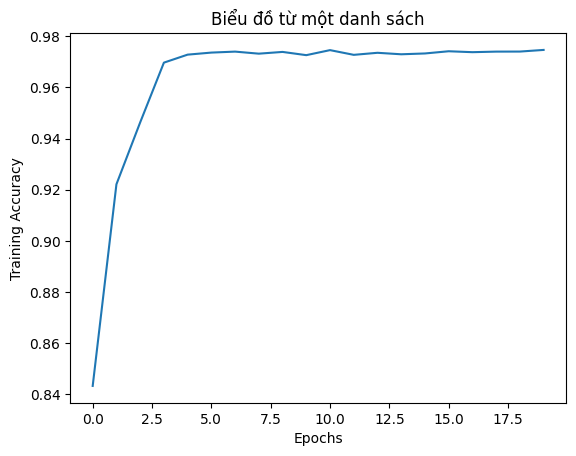

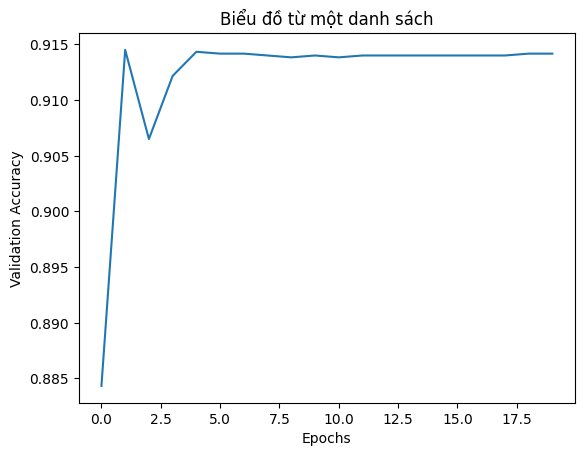

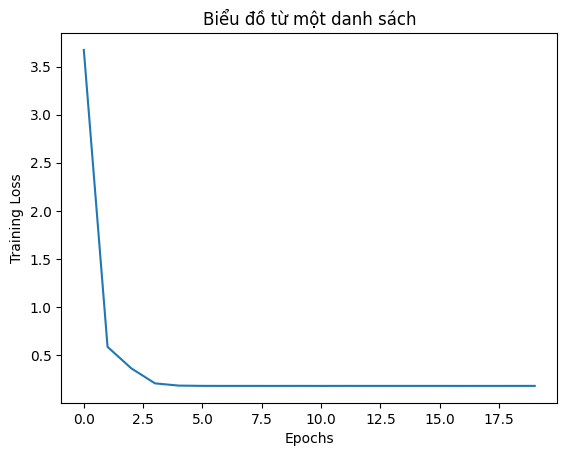

In [16]:
import matplotlib.pyplot as plt

plt.plot(total_train_acc)
plt.title('Biểu đồ từ một danh sách')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.show()

plt.plot(total_evaluate_acc)
plt.title('Biểu đồ từ một danh sách')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

plt.plot(train_losses)
plt.title('Biểu đồ từ một danh sách')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

In [20]:
print(min(train_losses))

0.17721608376747758


## Evaluate the model with test dataset

In [18]:
print("Checking the results of test dataset.")
accu_test, _ = evaluate(test_dataloader)
print("test accuracy {:8.3f}".format(accu_test))

Checking the results of test dataset.
test accuracy    0.919


## Test on Random news

In [19]:
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1

ex_text_str = "I want to play badminton"
model = model.to("cpu")
print("This is a %s news" % ag_news_label[predict(ex_text_str, text_pipeline)])

This is a Sports news


#### Save and Load Model 